In [2]:
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain_core.tools import tool
from typing import List

In [16]:
embedding_model = OllamaEmbeddings(model='bge-m3:latest')

vector_db = Chroma(
    embedding_function=embedding_model,
    collection_name="restaurant_menu",
    persist_directory="../../chroma_db"
)
@tool
def search_menu(query:str) -> List[str]:
    """
    레스토랑 메뉴에서 정보를 검색합니다.
    Args:
        query (str): _description_

    Returns:
        List[str]: _description_
    """
    docs = vector_db.similarity_search(query=query, k=2)
    formatted_docs = "\n\n---\n\n".join([
        f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>' for doc in docs
    ])
    
    if len(docs) > 0 :
        return formatted_docs
    return "관련 정보를 찾을 수 없습니다."

In [5]:
from langchain_community.tools import TavilySearchResults

@tool
def search_web(query:str) -> List[str]:
    """
    데이터베이스에 존재하지 않는 정보 또는 최신 정보를 인터넷에서 검색합니다.
    Args:
        query (str): _description_

    Returns:
        List[str]: _description_
    """
    tavily_search = TavilySearchResults(max_results=3)
    docs = tavily_search.invoke(query)
    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>' for doc in docs
        ]
    )
    if len(docs) > 0:
        return formatted_docs
    return "관련 정보를 찾을 수 없습니다."

In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini', streaming=True)

tools = [search_menu, search_web]

llm_with_tools = llm.bind_tools(tools=tools)

In [ ]:
from langchain_core.messages import HumanMessage

tool_call = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])

print(tool_call.additional_kwargs)

{'tool_calls': [{'index': 0, 'id': 'call_Gd0wzJBbTaFpyz3QlRN2Tb7T', 'function': {'arguments': '{"query":"스테이크"}', 'name': 'search_menu'}, 'type': 'function'}]}


In [8]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"LangGraph는 무엇인가요?")])
print(tool_call.additional_kwargs)

{'tool_calls': [{'index': 0, 'id': 'call_zCP1e5kj7pa8vmh012jstU0t', 'function': {'arguments': '{"query":"LangGraph"}', 'name': 'search_web'}, 'type': 'function'}]}


In [9]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"3+3은 얼마인가요?")])
print(tool_call.additional_kwargs)

{}


In [10]:
tool_call

AIMessage(content='3 + 3은 6입니다.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'}, id='run-1d7c5c92-fc57-4f3f-958c-517c85f4e7ac-0')

In [12]:
from langgraph.prebuilt import ToolNode

tool_node  = ToolNode(tools=tools)

In [14]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_AAxuWD7wHGaeNRDe0M4MWykX', 'function': {'arguments': '{"query":"스테이크"}', 'name': 'search_menu'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'}, id='run-3798717c-63b6-42d0-b965-bc98eb42da10-0', tool_calls=[{'name': 'search_menu', 'args': {'query': '스테이크'}, 'id': 'call_AAxuWD7wHGaeNRDe0M4MWykX', 'type': 'tool_call'}])

In [17]:
results = tool_node.invoke({"messages" :[tool_call]})

for result in results['messages']:
    print(result.content)
    print()

<Document source="../../data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.

2. 트러플 리조또
   • 가격: ₩22,000
   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈
   • 설명: 크리미한 텍스처의 리조또에 고급 블랙 트러플을 듬뿍 얹어 풍부한 향과 맛을 즐길 수 있는 메뉴입니다. 24개월 숙성된 파르미지아노 레지아노 치즈를 사용하여 깊은 맛을 더했으며, 주문 즉시 조리하여 최상의 상태로 제공됩니다.

3. 연어 타르타르
   • 가격: ₩18,000
   • 주요 식재료: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파
   • 설명: 신선한 노르웨이산 생연어를 곱게 다져 아보카도, 케이퍼, 적양파와 함께 섞어 만든 타르타르입니다. 레몬 드레싱으로 상큼한 맛을 더했으며, 바삭한 브리오쉬 토스트와 함께 제공됩니다. 전채요리로 완벽한 메뉴입니다.

4. 버섯 크림 수프
   • 가격: ₩10,000
   • 주요 식재료: 양송이버섯, 표고버섯, 생크림, 트러플 오일
   • 설명: 양송이버섯과 표고버섯을 오랜 시간 정성스레 끓여 만든 크림 수프입니다. 부드러운 텍스처와 깊은 버섯 향이 특징이며, 최상급 트러플 오일을 살짝 뿌려 고급스러운 향을 더했습니다. 파슬리를 곱게 다져 고명으로 올려 제공됩니다.

5. 가든 샐러드
   • 가격: ₩12,000
   • 주요 식재료: 유기농 믹스 그린, 체리 토마토, 오이, 당근, 발사믹 드레싱
   • 설명: 신선한 유기농 채소들로 구성된 건강한 샐러드입니다. 

In [18]:
results = tool_node.invoke({"messages":[llm_with_tools.invoke("LangGraph는 무엇인가요?")]})
for result in results['messages']:
    print(result.content)
    print()

<Document href="https://langchain-ai.github.io/langgraph/tutorials/introduction/"/>
[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-9-1)Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its components while adding graph-based coordination capabilities. It's particularly useful for developing more complex, [...] [](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-21-6)   LangGraph is a library designed for building stateful, multi-actor applications with Large Language Models (LLMs). It's particularly useful for creating agent and multi-agent workflows.
[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-21-7)
[](https://langchain-ai.github.io/langgraph/tutorial

In [21]:

from langgraph.prebuilt import create_react_agent
graph = create_react_agent(
    llm,
    tools=tools,
)

print(graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	agent(agent)
	tools(tools)
	__end__([<p>__end__</p>]):::last
	__start__ --> agent;
	tools --> agent;
	agent -.-> tools;
	agent -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [22]:
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_hTQr31FOTGdLWW5Uj3CXFAV0)
 Call ID: call_hTQr31FOTGdLWW5Uj3CXFAV0
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="../../data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.

2. 트러플 리조또
   • 가격: ₩22,000
   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈
   • 설명: 크리미한 텍스처의 리조또에 고급 블랙 트러플을 듬뿍 얹어 풍부한 향과 맛을 즐길 수 있는 메뉴입니다. 24개월 숙성된 파르미지아노 레지아노 치즈를 사용하여 깊은 맛을 더했으며, 주문 즉시 조리하여 최상의 상태로 제공됩니다.

3. 연어 타르타르
   • 가격: ₩18,000
   • 주요 식재료: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파
   • 설명: 신선한 노르웨이산 생연어를 곱게 다져 아보카도, 케이

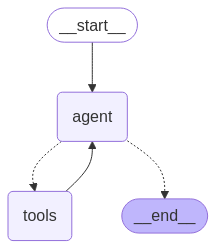

In [23]:
from textwrap import dedent
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display


# 시스템 프롬프트
system_prompt = dedent("""
You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크
    
    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니다...

    Action: search_web
    Action Input: History of AI

    (After receiving tool output)
    [Source: search_web | AI History | https://en.wikipedia.org/wiki/History_of_artificial_intelligence]
    AI의 역사는 다음과 같이 요약됩니다...

If tool use is not necessary, answer directly.

Your final answer should be clear, concise, and directly related to the user's question. 
Ensure that every piece of factual information in your response is accompanied by a citation.

Remember: ALWAYS include these citations for all factual information, tool outputs, and referenced documents in your response. 
Do not provide any information without a corresponding citation.
""")

# 그래프 생성 
graph = create_react_agent(
    llm, 
    tools=tools, 
    state_modifier=system_prompt,
    )

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))


In [24]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_zqP9y1DkARjXpEV6KsGJLPrT)
 Call ID: call_zqP9y1DkARjXpEV6KsGJLPrT
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="../../data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.

2. 트러플 리조또
   • 가격: ₩22,000
   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈
   • 설명: 크리미한 텍스처의 리조또에 고급 블랙 트러플을 듬뿍 얹어 풍부한 향과 맛을 즐길 수 있는 메뉴입니다. 24개월 숙성된 파르미지아노 레지아노 치즈를 사용하여 깊은 맛을 더했으며, 주문 즉시 조리하여 최상의 상태로 제공됩니다.

3. 연어 타르타르
   • 가격: ₩18,000
   • 주요 식재료: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파
   • 설명: 신선한 노르웨이산 생연어를 곱게 다져 아보카도, 케이

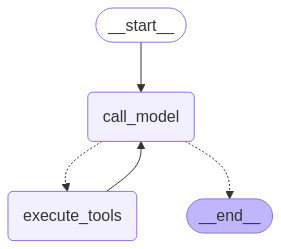

In [25]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# LangGraph MessagesState 사용
class GraphState(MessagesState):
    pass

# 노드 구성 
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: GraphState):
    last_message = state["messages"][-1]
    # 도구 호출이 있으면 도구 실행 노드로 이동
    if last_message.tool_calls:
        return "execute_tools"
    # 도구 호출이 없으면 답변 생성하고 종료 
    return END

# 그래프 구성
builder = StateGraph(GraphState)
builder.add_node("call_model", call_model)
builder.add_node("execute_tools", ToolNode(tools))

builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model", 
    should_continue,
    {
        "execute_tools": "execute_tools",
        END: END
    }
)
builder.add_edge("execute_tools", "call_model")

graph = builder.compile()

# 그래프 출력 
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_hioS22SM8MqvjA8r2Hui1zM7)
 Call ID: call_hioS22SM8MqvjA8r2Hui1zM7
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="../../data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.

2. 트러플 리조또
   • 가격: ₩22,000
   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈
   • 설명: 크리미한 텍스처의 리조또에 고급 블랙 트러플을 듬뿍 얹어 풍부한 향과 맛을 즐길 수 있는 메뉴입니다. 24개월 숙성된 파르미지아노 레지아노 치즈를 사용하여 깊은 맛을 더했으며, 주문 즉시 조리하여 최상의 상태로 제공됩니다.

3. 연어 타르타르
   • 가격: ₩18,000
   • 주요 식재료: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파
   • 설명: 신선한 노르웨이산 생연어를 곱게 다져 아보카도, 케이

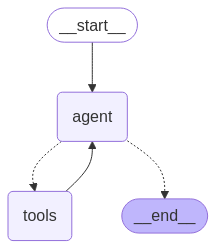

In [27]:
from langgraph.prebuilt import tools_condition

# 노드 함수 정의
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 그래프 구성
builder = StateGraph(GraphState)

builder.add_node("agent", call_model)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "agent")

# tools_condition을 사용한 조건부 엣지 추가
builder.add_conditional_edges(
    "agent",
    tools_condition,
)

builder.add_edge("tools", "agent")

graph = builder.compile()

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="파스타에 어울리는 음료는 무엇인가요?")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

파스타에 어울리는 음료는 무엇인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_UMYr8PJ6ldXHePksBqXi19ot)
 Call ID: call_UMYr8PJ6ldXHePksBqXi19ot
  Args:
    query: 파스타 음료
================================= Tool Message =================================
Name: search_menu

<Document source="../../data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.

2. 트러플 리조또
   • 가격: ₩22,000
   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈
   • 설명: 크리미한 텍스처의 리조또에 고급 블랙 트러플을 듬뿍 얹어 풍부한 향과 맛을 즐길 수 있는 메뉴입니다. 24개월 숙성된 파르미지아노 레지아노 치즈를 사용하여 깊은 맛을 더했으며, 주문 즉시 조리하여 최상의 상태로 제공됩니다.

3. 연어 타르타르
   • 가격: ₩18,000
   • 주요 식재료: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파
   • 설명: 신선한 노르웨이산 생연어를 곱게 다져 아보카도,

In [29]:
# 그래프 실행 - 이전 대화 내용을 기억하는지 못하는 문제가 있음 
inputs = {"messages": [HumanMessage(content="이 중에 하나만 추천해주세요.")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

이 중에 하나만 추천해주세요.
================================== Ai Message ==================================

추천하고 싶은 항목이 무엇인지 알려주시면 도와드리겠습니다. 어떤 선택지를 제공해 주셨나요?


In [30]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 초기화 
memory = MemorySaver()

# 체크포인터 지정하여 그래프 컴파일 
graph_memory = builder.compile(checkpointer=memory)

In [31]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]
messages = graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_pFC7p37zTRk68wxKHSp6dhd1)
 Call ID: call_pFC7p37zTRk68wxKHSp6dhd1
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="../../data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.

2. 트러플 리조또
   • 가격: ₩22,000
   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈
   • 설명: 크리미한 텍스처의 리조또에 고급 블랙 트러플을 듬뿍 얹어 풍부한 향과 맛을 즐길 수 있는 메뉴입니다. 24개월 숙성된 파르미지아노 레지아노 치즈를 사용하여 깊은 맛을 더했으며, 주문 즉시 조리하여 최상의 상태로 제공됩니다.

3. 연어 타르타르
   • 가격: ₩18,000
   • 주요 식재료: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파
   • 설명: 신선한 노르웨이산 생연어를 곱게 다져 아보카도, 케이

In [32]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="둘 중에 더 저렴한 메뉴는 무엇인가요?")]
messages = graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_pFC7p37zTRk68wxKHSp6dhd1)
 Call ID: call_pFC7p37zTRk68wxKHSp6dhd1
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="../../data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.

2. 트러플 리조또
   • 가격: ₩22,000
   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈
   • 설명: 크리미한 텍스처의 리조또에 고급 블랙 트러플을 듬뿍 얹어 풍부한 향과 맛을 즐길 수 있는 메뉴입니다. 24개월 숙성된 파르미지아노 레지아노 치즈를 사용하여 깊은 맛을 더했으며, 주문 즉시 조리하여 최상의 상태로 제공됩니다.

3. 연어 타르타르
   • 가격: ₩18,000
   • 주요 식재료: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파
   • 설명: 신선한 노르웨이산 생연어를 곱게 다져 아보카도, 케이

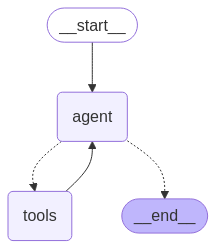

In [33]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

# 메모리 초기화 
memory = MemorySaver()

# 그래프 생성 
graph = create_react_agent(
    llm, 
    tools=tools, 
    state_modifier=system_prompt,
    checkpointer=memory,
    )

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
config = {"configurable": {"thread_id": "2"}}
messages = [HumanMessage(content="채식주의자를 위한 메뉴가 있나요?")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

채식주의자를 위한 메뉴가 있나요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_8MJXSGOXVAJCnZ5vowKgDucr)
 Call ID: call_8MJXSGOXVAJCnZ5vowKgDucr
  Args:
    query: 채식주의자 메뉴
================================= Tool Message =================================
Name: search_menu

<Document source="../../data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.

2. 트러플 리조또
   • 가격: ₩22,000
   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈
   • 설명: 크리미한 텍스처의 리조또에 고급 블랙 트러플을 듬뿍 얹어 풍부한 향과 맛을 즐길 수 있는 메뉴입니다. 24개월 숙성된 파르미지아노 레지아노 치즈를 사용하여 깊은 맛을 더했으며, 주문 즉시 조리하여 최상의 상태로 제공됩니다.

3. 연어 타르타르
   • 가격: ₩18,000
   • 주요 식재료: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파
   • 설명: 신선한 노르웨이산 생연어를 곱게 다져 아보카도,

In [35]:
config = {"configurable": {"thread_id": "2"}}
messages = [HumanMessage(content="방금 답변에 대한 출처가 있나요?")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

채식주의자를 위한 메뉴가 있나요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_8MJXSGOXVAJCnZ5vowKgDucr)
 Call ID: call_8MJXSGOXVAJCnZ5vowKgDucr
  Args:
    query: 채식주의자 메뉴
================================= Tool Message =================================
Name: search_menu

<Document source="../../data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.

2. 트러플 리조또
   • 가격: ₩22,000
   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈
   • 설명: 크리미한 텍스처의 리조또에 고급 블랙 트러플을 듬뿍 얹어 풍부한 향과 맛을 즐길 수 있는 메뉴입니다. 24개월 숙성된 파르미지아노 레지아노 치즈를 사용하여 깊은 맛을 더했으며, 주문 즉시 조리하여 최상의 상태로 제공됩니다.

3. 연어 타르타르
   • 가격: ₩18,000
   • 주요 식재료: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파
   • 설명: 신선한 노르웨이산 생연어를 곱게 다져 아보카도,

In [ ]:
import gradio as gr
from typing import List, Tuple
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
import uuid

# 메모리 사용 준비
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# 예시 질문들
example_questions = [
    "채식주의자를 위한 메뉴를 추천해주세요.",
    "오늘의 스페셜 메뉴는 무엇인가요?",
    "파스타에 어울리는 음료는 무엇인가요?"
]

# 답변 메시지 처리를 위한 함수
def process_message(message: str, history: List[Tuple[str, str]], thread_id: str) -> str:
    try:
        config = {"configurable": {"thread_id": thread_id}}
        inputs = {"messages": [HumanMessage(content=message)]}
        
        result = graph_memory.invoke(inputs, config=config)
        
        if "messages" in result:
            # 메시지 로깅 (선택사항)
            print(f"스레드 ID: {thread_id}")
            for msg in result["messages"]:
                msg.pretty_print()

            last_message = result["messages"][-1]
            if isinstance(last_message, AIMessage):
                return last_message.content

        return "응답을 생성하지 못했습니다."

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return "죄송합니다. 응답을 생성하는 동안 오류가 발생했습니다. 다시 시도해 주세요."


# 챗봇 클래스 생성
class ChatBot:
    def __init__(self):
        self.thread_id = str(uuid.uuid4())

    def chat(self, message: str, history: List[Tuple[str, str]]) -> str:
        print(f"Thread ID: {self.thread_id}")
        response = process_message(message, history, self.thread_id)
        return response

chatbot = ChatBot()


# ChatInterface 생성
demo = gr.ChatInterface(
    fn=chatbot.chat,
    title="레스토랑 메뉴 AI 어시스턴트",
    description="메뉴 정보, 추천, 음식 관련 질문에 답변해 드립니다. 정보의 출처를 함께 제공합니다.",
    examples=example_questions,
    theme=gr.themes.Soft()
)

# Gradio 앱 실행
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Thread ID: 0f013b7d-5fd7-42ce-9888-a9f2752130c3
스레드 ID: 0f013b7d-5fd7-42ce-9888-a9f2752130c3
================================ Human Message =================================

채식주의자를 위한 메뉴를 추천해주세요.
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_Q9FgDwemudThygtRZuGfaGmq)
 Call ID: call_Q9FgDwemudThygtRZuGfaGmq
  Args:
    query: 채식주의자 메뉴
================================= Tool Message =================================
Name: search_menu

<Document source="../../data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.

2. 트러플 리조또
   • 가격: ₩22,000
   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈
   • 설명: 크리미한 텍스처의 리조또에 고급 블랙 트러플을 듬뿍 얹어 풍부한 향과 맛을 즐길 수 있는 메뉴입니다. 24개월 숙성된 파르미지아노 레지아노 치즈를 사용하여 깊은 맛을 더했으며, 주문 즉시 조리하여 최상의 상태로 제공됩니다.

3. 연어 

In [38]:
demo.close()

Closing server running on port: 7860
